# Epeak_Eiso_cosmology.ipynb
We have searched for a $E_\text{peak}$-$E_\text{iso}$ fit in [Epeak_Eiso_correlation.ipynb](https://github.com/joanalnu/OAB-INAF/blob/main/Epeak_Eiso_correlation.ipynb) and computed $E_\text{iso}$ from respective fluences $S$ in dependency of cosmology. In this notebook, we employ that to constrain the cosmological parameters, searching for $E_\text{peak}$-$E_\text{iso}$ fit with less scatter (i.e. shorter point-fit distances), indicating the 'best cosmology.'

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
from scipy.stats import norm

In [3]:
# read data
df = pd.read_csv('table.csv')

Epeak = np.log10(df['Epeak'])
Epeak_err = np.log10(df['Epeak_err'])
z = df['z']
S = df['Fluence']  # ergs/cm2
S_err = df['Fluence_err']


# Convert H0 to cgs units: H0 [s^-1] = H0 [km/s/Mpc] * (km/Mpc to 1/s conversion)
# 1 Mpc = 3.086e24 cm, so H0_cgs = H0_kmsMpc * 1e5 / 3.086e24
H0_cgs = 70.0 * 1e5 / 3.086e24  # s^-1
c = 29979245800  # cm/s
Om_default = 0.3
Ode_default = 0.7
c = 2.99792458e10  # cm/s

def luminosity_distance(redshift, Ho=H0_cgs, O_m=Om_default, O_DE=Ode_default):
    """
    Calculate luminosity distance for given redshift(s) and cosmological parameters.

    Parameters:
    -----------
    redshift : float or array
        Redshift value(s)
    Ho : float
        Hubble constant in cgs units (s^-1)
    O_m : float
        Matter density parameter
    O_DE : float
        Dark energy density parameter

    Returns:
    --------
    float or array
        Luminosity distance in cm
    """

    def luminosity_distance_single(z, Ho=Ho, O_m=O_m, O_DE=O_DE):
        def integrand(z_prime):
            return 1.0 / np.sqrt(O_m * (1 + z_prime)**3 + O_DE)

        # Create redshift sample array
        z_array = np.linspace(0, z, num=1000)

        # Evaluate integrand on array
        y_values = integrand(z_array)

        # Compute definite integral from 0 to z
        integral = cumulative_trapezoid(y_values, z_array, initial=0)[-1]

        # Compute luminosity distance
        return (c * (1 + z) / Ho) * integral

    # Handle scalar and array inputs
    if np.isscalar(redshift):
        return luminosity_distance_single(redshift, Ho, O_m, O_DE)
    else:
        return np.array([luminosity_distance_single(z_i, Ho, O_m, O_DE) for z_i in redshift])

def curved_luminosity_distance(redshift, Ho=H0_cgs, O_m=Om_default, O_DE=Ode_default):
    """
    As luminosity_distance(), this function calculated the luminosity distance for given redshift(s) and cosmological parameters. However, this function does not assume a flat LambdaCDM model and instead uses Ok = 1.0-Ode-Om.
    :param redshift: float or array; Redshift value(s)
    :param Ho: hubble constant in cgs units (s^-1)
    :param O_m: matter density parameter
    :param O_DE: dark energy density parameter
    :return: float or array; luminosity distance in cm
    """

    def luminosity_distance_single(z, Ho=Ho, O_k=(1.0-O_m-O_DE), O_m=O_m, O_DE=O_DE):
        def integrand(z_prime):
            return 1.0/np.sqrt(O_m * (1 + z_prime)**3 + O_DE + O_k*(1+z_prime)**2)

        z_array = np.linspace(0,z,num=1000)
        y_values = integrand(z_array)
        integral = cumulative_trapezoid(y_values, z_array, initial=0)[-1]
        constants = (c * (1+z)/Ho)
        return constants*integral

    O_k = 1.0 - O_DE - O_m
    if np.isscalar(redshift):
        return luminosity_distance_single(redshift, Ho, O_k, O_m, O_DE)
    else:
        return np.array([luminosity_distance_single(z_i, Ho, O_k, O_m, O_DE) for z_i in redshift])

def isotropic_equivalent_energy(redshift, fluence, H0=H0_cgs, Omega_m=Om_default, Omega_DE=Ode_default):
    """
    Calculate the isotropic equivalent energy.

    Parameters:
    -----------
    redshift : float or array
        Redshift value(s)
    fluence : float or array
        Observed fluence (should be in erg/cm^2)
    H0 : float
        Hubble constant in cgs units (s^-1)
    Omega_m : float
        Matter density parameter
    Omega_DE : float
        Dark energy density parameter

    Returns:
    --------
    float or array
        Log10 of isotropic equivalent energy
    """
    d_L = curved_luminosity_distance(redshift, H0_cgs, Omega_m, Omega_DE)
    numerator = 4.0 * np.pi * (d_L ** 2) * fluence
    return np.log10(numerator / (1 + redshift))

def measure_distances(a, b, x, y):
    """
    Measures the distance between a point p = (x,y) and a line of best fit y=ax+b.
    :param p: coordinates of the point
    :param a: slope of the fit
    :param b: y-axis cut of the fit
    :return: scalar for the distance
    """
    # for the line point we use x0=0 and thus y0=b
    numerator = abs(a*x -y +b)
    denominator = np.sqrt(1 + (a ** 2))
    return numerator / denominator

def GoF(m,k,x,y):
    """
    Goodness of fit following the chi-squared formula
    :param m: slope
    :param k: y-axis cut
    :param x: x-values
    :param y: y-values
    :return: chi-squared value
    """
    model = m*x + k
    chi_squared = np.sum((y-model)**2)
    return chi_squared

0 0	Om=0.000, Ode=0.000, m_fit=0.458, k_fit=-21.667
0 1	Om=0.000, Ode=0.222, m_fit=0.458, k_fit=-21.667
0 2	Om=0.000, Ode=0.444, m_fit=0.458, k_fit=-21.667
0 3	Om=0.000, Ode=0.667, m_fit=0.458, k_fit=-21.667
0 4	Om=0.000, Ode=0.889, m_fit=0.458, k_fit=-21.667
1 0	Om=0.222, Ode=0.000, m_fit=0.500, k_fit=-23.750
1 1	Om=0.222, Ode=0.222, m_fit=0.500, k_fit=-23.750


/var/folders/lq/7_q5kjhn1pzgzvpl0fk8y5mc0000gp/T/ipykernel_12732/1140892461.py:74: RuntimeWarning: invalid value encountered in sqrt
  return 1.0/np.sqrt(O_m * (1 + z_prime)**3 + O_DE + O_k*(1+z_prime)**2)


1 2	Om=0.222, Ode=0.444, m_fit=0.458, k_fit=-21.667
1 3	Om=0.222, Ode=0.667, m_fit=0.458, k_fit=-21.667
1 4	Om=0.222, Ode=0.889, m_fit=0.458, k_fit=-21.667
1 5	Om=0.222, Ode=1.111, m_fit=0.458, k_fit=-21.667
1 6	Om=0.222, Ode=1.333, m_fit=0.500, k_fit=-23.958
1 7	Om=0.222, Ode=1.556, m_fit=0.458, k_fit=-21.875
2 0	Om=0.444, Ode=0.000, m_fit=0.500, k_fit=-23.750
2 1	Om=0.444, Ode=0.222, m_fit=0.500, k_fit=-23.750


/var/folders/lq/7_q5kjhn1pzgzvpl0fk8y5mc0000gp/T/ipykernel_12732/1140892461.py:74: RuntimeWarning: divide by zero encountered in divide
  return 1.0/np.sqrt(O_m * (1 + z_prime)**3 + O_DE + O_k*(1+z_prime)**2)


2 2	Om=0.444, Ode=0.444, m_fit=0.500, k_fit=-23.750
2 3	Om=0.444, Ode=0.667, m_fit=0.458, k_fit=-21.667
2 4	Om=0.444, Ode=0.889, m_fit=0.458, k_fit=-21.667
2 5	Om=0.444, Ode=1.111, m_fit=0.458, k_fit=-21.667
2 6	Om=0.444, Ode=1.333, m_fit=0.458, k_fit=-21.667
2 7	Om=0.444, Ode=1.556, m_fit=0.500, k_fit=-23.958
2 8	Om=0.444, Ode=1.778, m_fit=0.458, k_fit=-21.875
3 0	Om=0.667, Ode=0.000, m_fit=0.458, k_fit=-21.458
3 1	Om=0.667, Ode=0.222, m_fit=0.500, k_fit=-23.750
3 2	Om=0.667, Ode=0.444, m_fit=0.500, k_fit=-23.750
3 3	Om=0.667, Ode=0.667, m_fit=0.500, k_fit=-23.750
3 4	Om=0.667, Ode=0.889, m_fit=0.500, k_fit=-23.750
3 5	Om=0.667, Ode=1.111, m_fit=0.458, k_fit=-21.667
3 6	Om=0.667, Ode=1.333, m_fit=0.458, k_fit=-21.667
3 7	Om=0.667, Ode=1.556, m_fit=0.458, k_fit=-21.667
3 8	Om=0.667, Ode=1.778, m_fit=0.458, k_fit=-21.667
3 9	Om=0.667, Ode=2.000, m_fit=0.458, k_fit=-21.875
4 0	Om=0.889, Ode=0.000, m_fit=0.458, k_fit=-21.458
4 1	Om=0.889, Ode=0.222, m_fit=0.458, k_fit=-21.458
4 2	Om=0.889

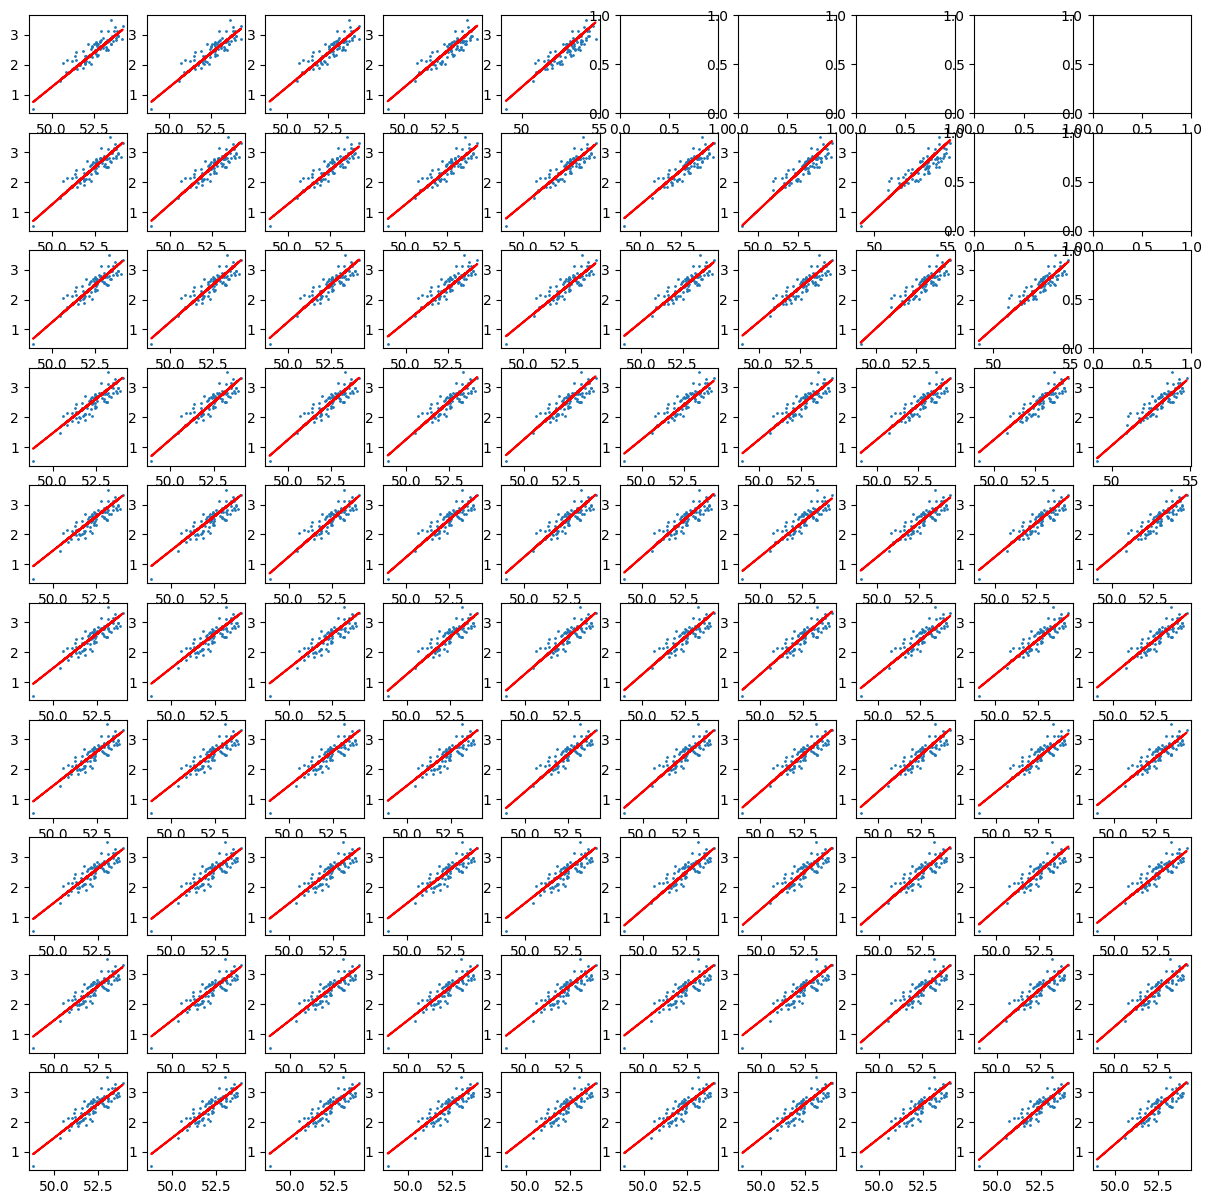

In [11]:
# Define cosmological parameter grids
Om = np.linspace(0.0,2.0,25)
Ode = np.linspace(0.0,2.0,25)
k = np.linspace(-25.,-20.,25) # from the previous scatter plot, we can infer that the y-axis cut is around -25 and -20
m = np.linspace(0.0,1.0,25) # the slope must be positive

data = np.zeros([len(Om), len(Ode), len(df['Eiso'])])
# this 3D array consist of a Om-Ode 2 grid and the depth corresponding to the distance for aech of the 75 points (25x25x75)
fig, ax = plt.subplots(len(Om), len(Ode), figsize=(15,15))
for i in range(len(Om)):
    for j in range(len(Ode)):
        try:
            isotropic_model = isotropic_equivalent_energy(z,S,H0_cgs,Om[i],Ode[j])

            # check for NaN or inf values
            if np.any(~np.isfinite(isotropic_model)):
                data[i,j,:] = np.inf # instead of NaN which creates problems when finding minimum with argmin
                continue

            G = np.zeros([len(m), len(k)]) # G[i,j] corresponds to m[i], k[j]
            for mu in range(len(m)):
                for nu in range(len(k)):
                    G[mu,nu] = GoF(m[mu], k[nu], x=isotropic_model, y=Epeak)

            # extract best fit parameters
            best_fit = np.argmin(G)
            m_index, k_index = np.unravel_index(best_fit, G.shape)
            m_fit, k_fit = m[m_index], k[k_index]
            data[i,j,:] = measure_distances(m_fit, k_fit, isotropic_model, Epeak)
            print(f'{i} {j}\tOm={Om[i]:.3f}, Ode={Ode[j]:.3f}, m_fit={m_fit:.3f}, k_fit={k_fit:.3f}')

            ax[i, j].scatter(isotropic_model, Epeak, s=1)
            ax[i, j].plot(isotropic_model, m_fit * isotropic_model + k_fit, c='r')

        except Exception as e:
            print(f'Error at Om={Om[i]:.3f}, Ode={Ode[j]:.3f}: {e}')
            data[i,j,:] = np.inf # mark as invalid

np.save(f'4x{len(Om)}distances.npy', data)

Instead of computing the sum of the distances (liek with $\chi^2$ method), we are going to plot an histogram of the distribution of distances for each combination of $(\Omega_m, \Omega_{DE})$ and find the mean by fitting a gaussian of the form of:
$$\phi (x; \mu, \sigma ) = \frac{1}{\sigma \sqrt{2 \pi}} \exp \left( {-\frac{(x-\mu)^2}{2\sigma^2}} \right)$$

ValueError: The data contains non-finite values.

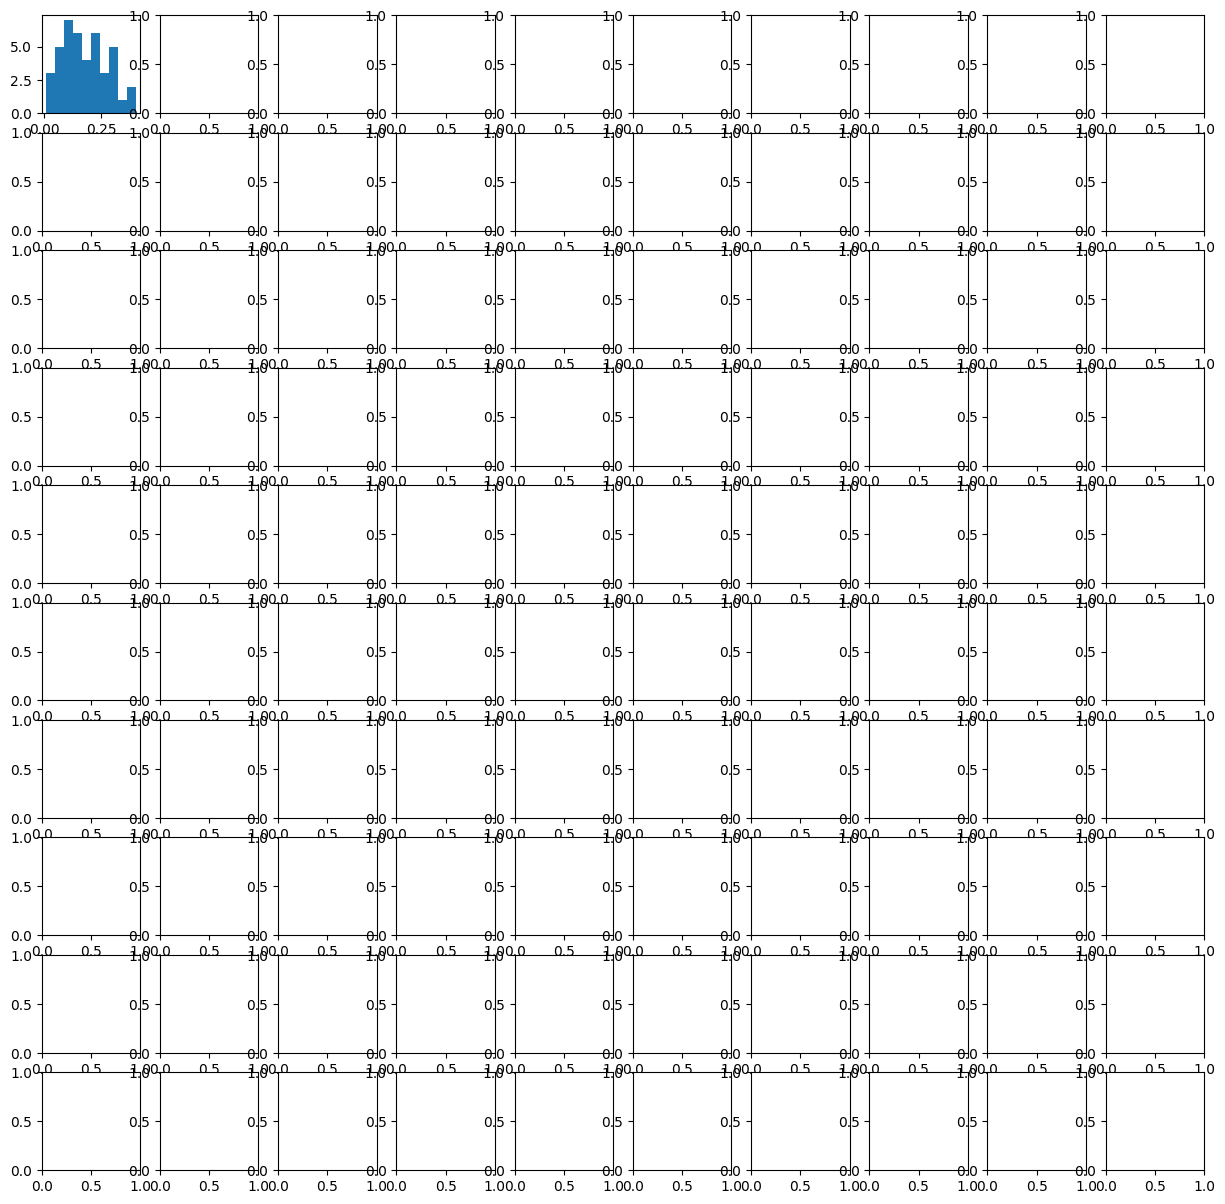

In [45]:
# load correct data
d = np.load(f'4x{len(Om)}distances.npy')
means = np.zeros([len(Om), len(Ode)])

def gaussian(x, mu, sigma):
    return (1/sigma*np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*sigma**2)) # gaussian function

# plot an histogram for each one
fig, ax = plt.subplots(len(Om), len(Ode), figsize=(15,15))
for i in range(len(Om)):
    for j in range(len(Ode)):
        if (np.inf in d[i,j,:] and np.nan in d[i,j,:]) or (np.inf in d[i,j,:] or np.nan in d[i,j,:]):
            ax[i,j].annotate('inf',(.5,.5))
            continue
        ax[i,j].hist(d[i,j,:])
        (mu, sigma) = norm.fit(d[i,j,:]) # gaussian of best fit using scipy
        x_data = np.linspace(np.min(d[i,j,:]), np.max(d[i,j,:]),100)
        ax[i,j].plot(x_data, gaussian(x_data, mu, sigma), c='r')
        ax[i,j].vlines(mu, 0, 20, colors='red', linestyles='--')
        means[i,j] = mu

Best fit: Om=0.000, Ode=0.444
Minimum average distance: 0.163


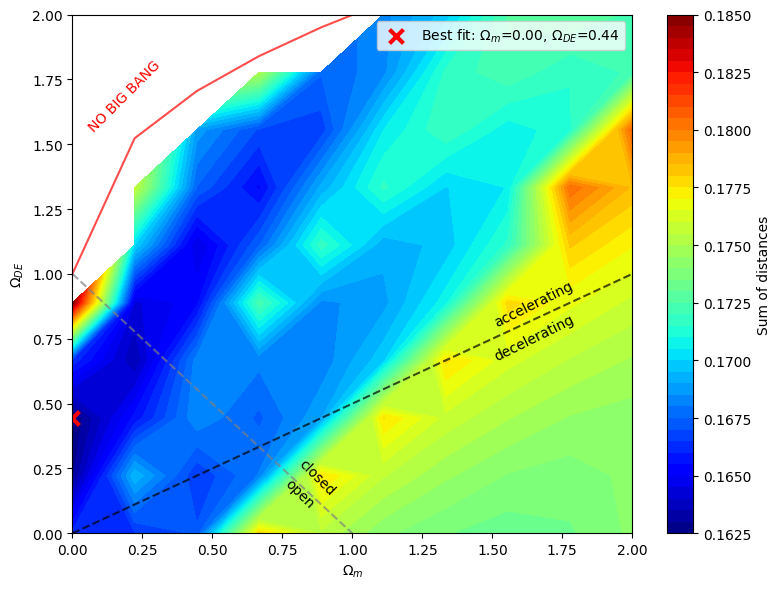

In [31]:
# now let's plot the (Om, Ode)mean surface

# Create a proper mask for unphysical regions
# instead of a simple mask, the proper mask ensures that values aren't marked as NaN or 0, important for the argmin results
mask = np.zeros_like(means, dtype=bool)
for i in range(len(Om)):
    for j in range(len(Ode)):
        if (#Om[i]+Ode[j]>1.2 or # approx flat-universe region
                #Om[i]+Ode[j]<0.8 or
                Ode[j] >= Om[i]** (1/2.32) + 1.0 or # approx no big bang area
                not np.isfinite(means[i, j])):
            mask[i,j]=True

masked_means = np.ma.masked_where(mask, means)

best_fit = np.argmin(masked_means)
Om_index, Ode_index = np.unravel_index(best_fit, masked_means.shape)
Om_fit, Ode_fit = Om[Om_index], Ode[Ode_index]

print(f'Best fit: Om={Om_fit:.3f}, Ode={Ode_fit:.3f}')
print(f'Minimum average distance: {masked_means[Om_index,Ode_index]:.3}')


# Plot
plt.figure(figsize=(8, 6))
im = plt.contourf(Om, Ode, masked_means.T, cmap='jet', levels=50)
plt.colorbar(im, label='Distances mean')
plt.scatter(Om_fit, Ode_fit, c='red', marker='x', s=100, linewidth=3, label=fr'Best fit: $\Omega_m$={Om_fit:.2f}, $\Omega_{'{DE}'}$={Ode_fit:.2f}')

plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_{DE}$')

# Add constraint lines
plt.plot(Om, 0.5*Om, linestyle='--', color='black', alpha=0.7)
plt.annotate('accelerating', (1.5,0.80), rotation=26.35)
plt.annotate('decelerating', (1.5,0.67), rotation=26.35)

plt.plot(Om, Om**(1/2.32)+1, c='r', alpha=0.7)
plt.annotate('NO BIG BANG', (0.05,1.55), rotation=45, color='red')

plt.plot(Om, 1-Om, linestyle='--', color='gray', alpha=0.7)
plt.annotate('open', (0.75,0.1), rotation=-45)
plt.annotate('closed', (0.8,0.15), rotation=-45)

plt.legend()
plt.xlim(0.0,2.0)
plt.ylim(0.0,2.0)
plt.tight_layout()

Text(0, 0.5, '$D_L$')

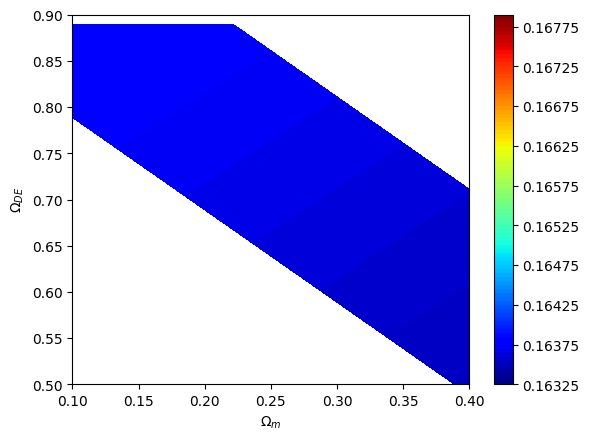

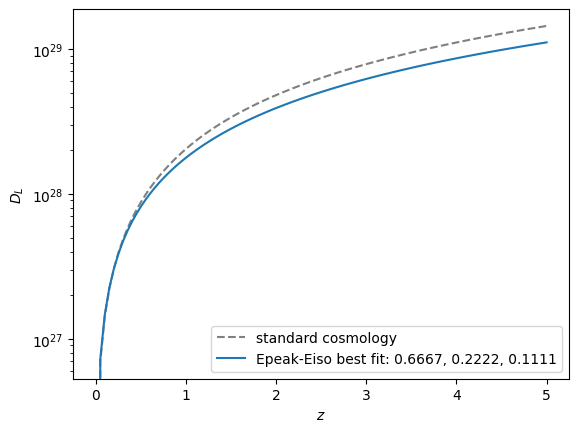

In [42]:
plt.figure()
plt.contourf(Om, Ode, masked_means.T, cmap='jet', levels=100)
plt.colorbar()
plt.scatter(Om_fit, Ode_fit, c='r', marker='x')
plt.xlim(0.1,0.4)
plt.ylim(0.5,0.9)
plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$\Omega_{DE}$')

z_plot = np.linspace(0.,5.,100)

plt.figure()
plt.plot(z_plot, luminosity_distance(z_plot), label=f'standard cosmology', color='grey', linestyle='--')
plt.plot(z_plot, luminosity_distance(z_plot, O_m=Om_fit, O_DE=Ode_fit), label=f'Epeak-Eiso best fit: {Om_fit:.4f}, {Ode_fit:.4f}, {(1.0-Om_fit-Ode_fit):.4f}')
plt.legend()
plt.yscale('log')
plt.xlabel(r'$z$')
plt.ylabel(r'$D_L$')